# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

# Imports

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocessor
from keras_hist_graph import plot_history
from sklearn.metrics import confusion_matrix
import itertools

from utils import load_images, plot_accuracy_and_loss, plot_smoothed_acc_and_loss, extract_features

Using TensorFlow backend.


In [2]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (50,50))
    plt.figure(figsize = (15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

In [3]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Parameters

In [4]:
train_dir = 'dogs_299/train/'
validation_dir = 'dogs_299/validation/'
test_dir = 'dogs_299/test/'

STD_SIZE = (299, 299)
BATCH_SIZE = 20
ENVIRONNEMENT = 'local'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

# 2 breeds

## Data Preparation

In [5]:
classes = ['Chihuahua', 'Japanese_spaniel']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 236 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 51 images belonging to 2 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel']

Loaded test images in test_features array: (51, 299, 299, 3)


# Model

In [6]:
conv_base = InceptionV3(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

for i, layer in enumerate(conv_base.layers):
   print(i, layer.name)

In [7]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [8]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

conv_base.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_inceptV3_data_aug_2_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_inceptV3_data_aug_2_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 13s - loss: 0.7803 - acc: 0.6898 - val_loss: 0.0252 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.02519, saving model to tl_freeze_conv_base_inceptV3_data_aug_2_breeds
Epoch 2/1000
 - 5s - loss: 0.2879 - acc: 0.8750 - val_loss: 0.2270 - val_acc: 0.8667

Epoch 00002: val_loss did not improve from 0.02519
Epoch 3/1000
 - 4s - loss: 0.3771 - acc: 0.8704 - val_loss: 0.0299 - val_acc: 1.0000

Epoch 00003: val_loss did not improve from 0.02519
Epoch 4/1000
 - 4s - loss: 0.2254 - acc: 0.9000 - val_loss: 0.0030 - val_acc: 1.0000

Epoch 00004: val_loss improved from 0.02519 to 0.00295, saving model to tl_freeze_conv_base_inceptV3_data_aug_2_breeds
Epoch 5/1000
 - 3s - loss: 0.2733 - acc: 0.8981 - val_loss: 0.0076 - val_acc: 1.0000

Epoch 00005: val_loss did not improve from 0.00295
Epoch 6/1000
 - 4s - loss: 0.2061 - acc: 0.9213 - val_loss: 0.0015 - val_acc: 1.0000

Epoch 00006: val_loss improved from 0.00295 to 0.00155, saving model to tl_freeze_conv_base_ince

## Results

In [9]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

51/51 [==============================] - 2s 34ms/step


[0.02763006385369511, 0.9803921580314636]

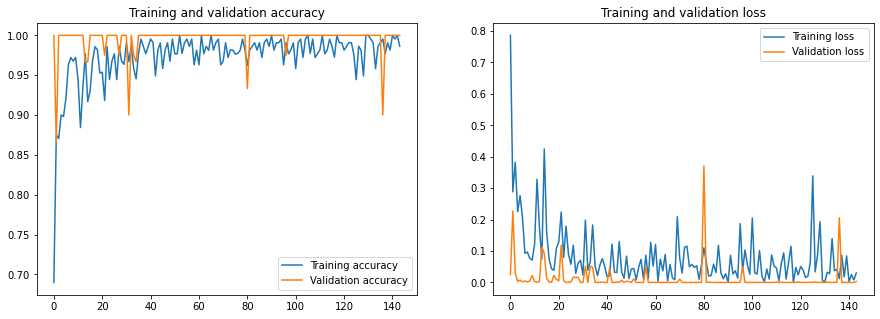

In [10]:
plot_accuracy_and_loss(history)

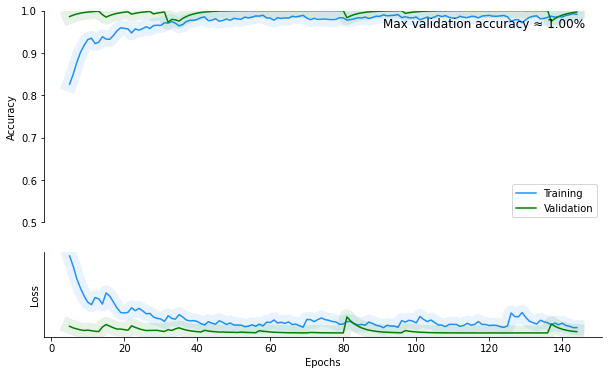

In [11]:
plot_history(history,xkcd=False)

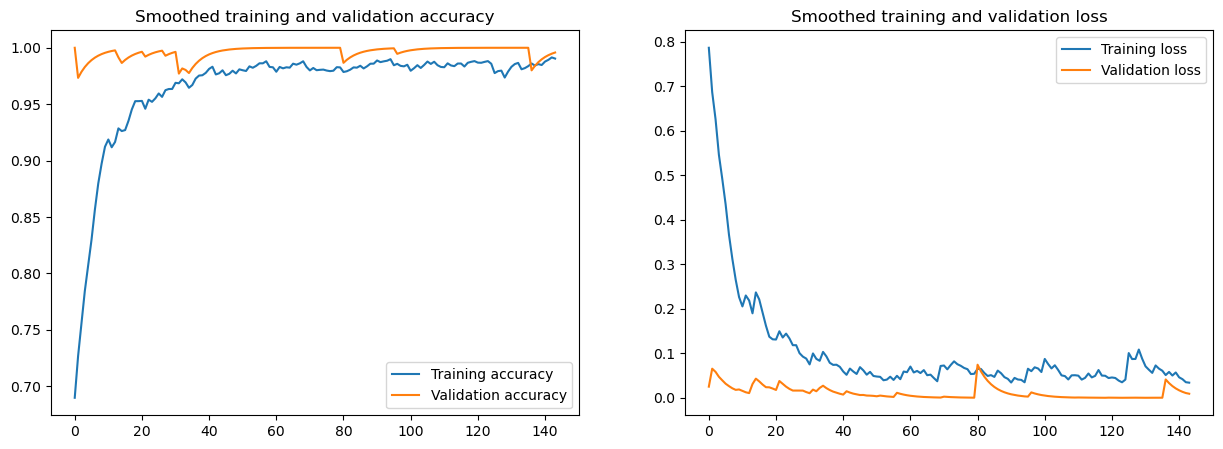

In [12]:
plot_smoothed_acc_and_loss(history, 0.8)

# 3 breeds

## Data preparation

In [13]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 412 images belonging to 3 classes.
Found 88 images belonging to 3 classes.
Found 89 images belonging to 3 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

Loaded test images in test_features array: (89, 299, 299, 3)


## Model

In [14]:
conv_base = InceptionV3(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [15]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
_______________________________________________________________________________________

In [16]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

conv_base.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_inceptV3_data_aug_3_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_inceptV3_data_aug_3_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 10s - loss: 0.9760 - acc: 0.6786 - val_loss: 0.2447 - val_acc: 0.9625

Epoch 00001: val_loss improved from inf to 0.24468, saving model to tl_freeze_conv_base_inceptV3_data_aug_3_breeds
Epoch 2/1000
 - 9s - loss: 0.5050 - acc: 0.8138 - val_loss: 0.0254 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.24468 to 0.02541, saving model to tl_freeze_conv_base_inceptV3_data_aug_3_breeds
Epoch 3/1000
 - 7s - loss: 0.4021 - acc: 0.8750 - val_loss: 0.0355 - val_acc: 0.9853

Epoch 00003: val_loss did not improve from 0.02541
Epoch 4/1000
 - 7s - loss: 0.2250 - acc: 0.9107 - val_loss: 0.0034 - val_acc: 0.9853

Epoch 00004: val_loss improved from 0.02541 to 0.00336, saving model to tl_freeze_conv_base_inceptV3_data_aug_3_breeds
Epoch 5/1000
 - 7s - loss: 0.2460 - acc: 0.9031 - val_loss: 0.1632 - val_acc: 0.9559

Epoch 00005: val_loss did not improve from 0.00336
Epoch 6/1000
 - 7s - loss: 0.2393 - acc: 0.8954 - val_loss: 0.0014 - val_acc: 1.0000

Epoch 00006: val_loss improv

## Results

In [17]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

89/89 [==============================] - 2s 22ms/step


[0.02105290915392033, 0.9887640476226807]

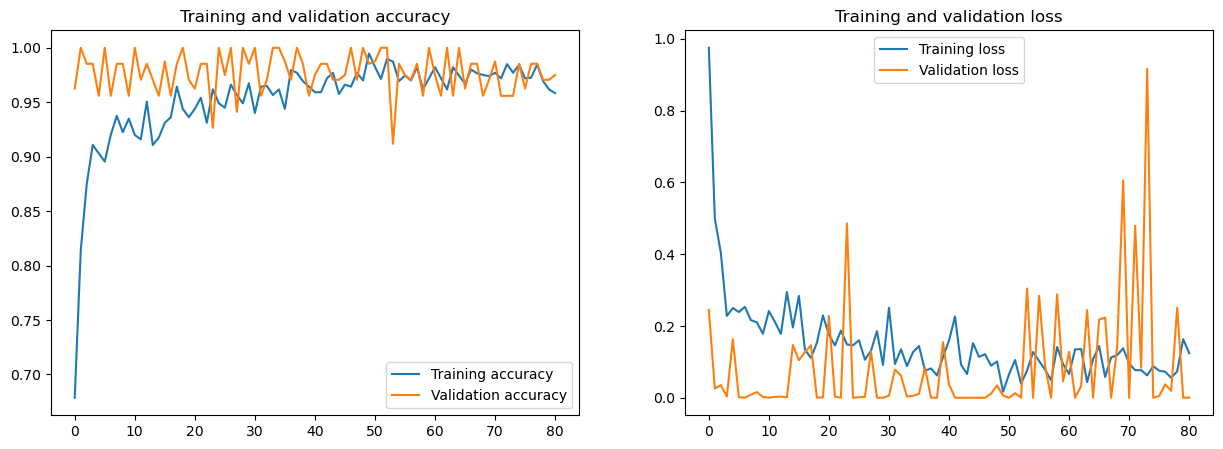

In [18]:
plot_accuracy_and_loss(history)

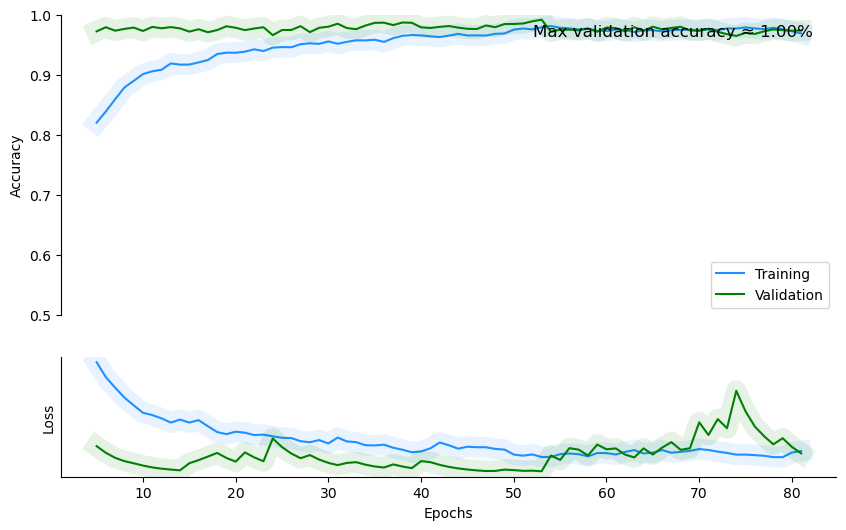

In [19]:
plot_history(history,xkcd=False)

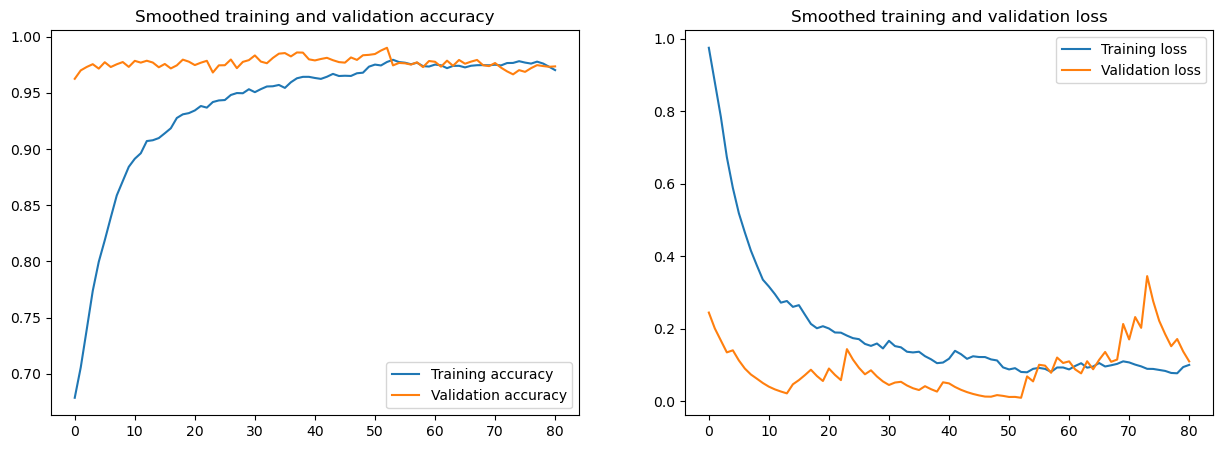

In [20]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

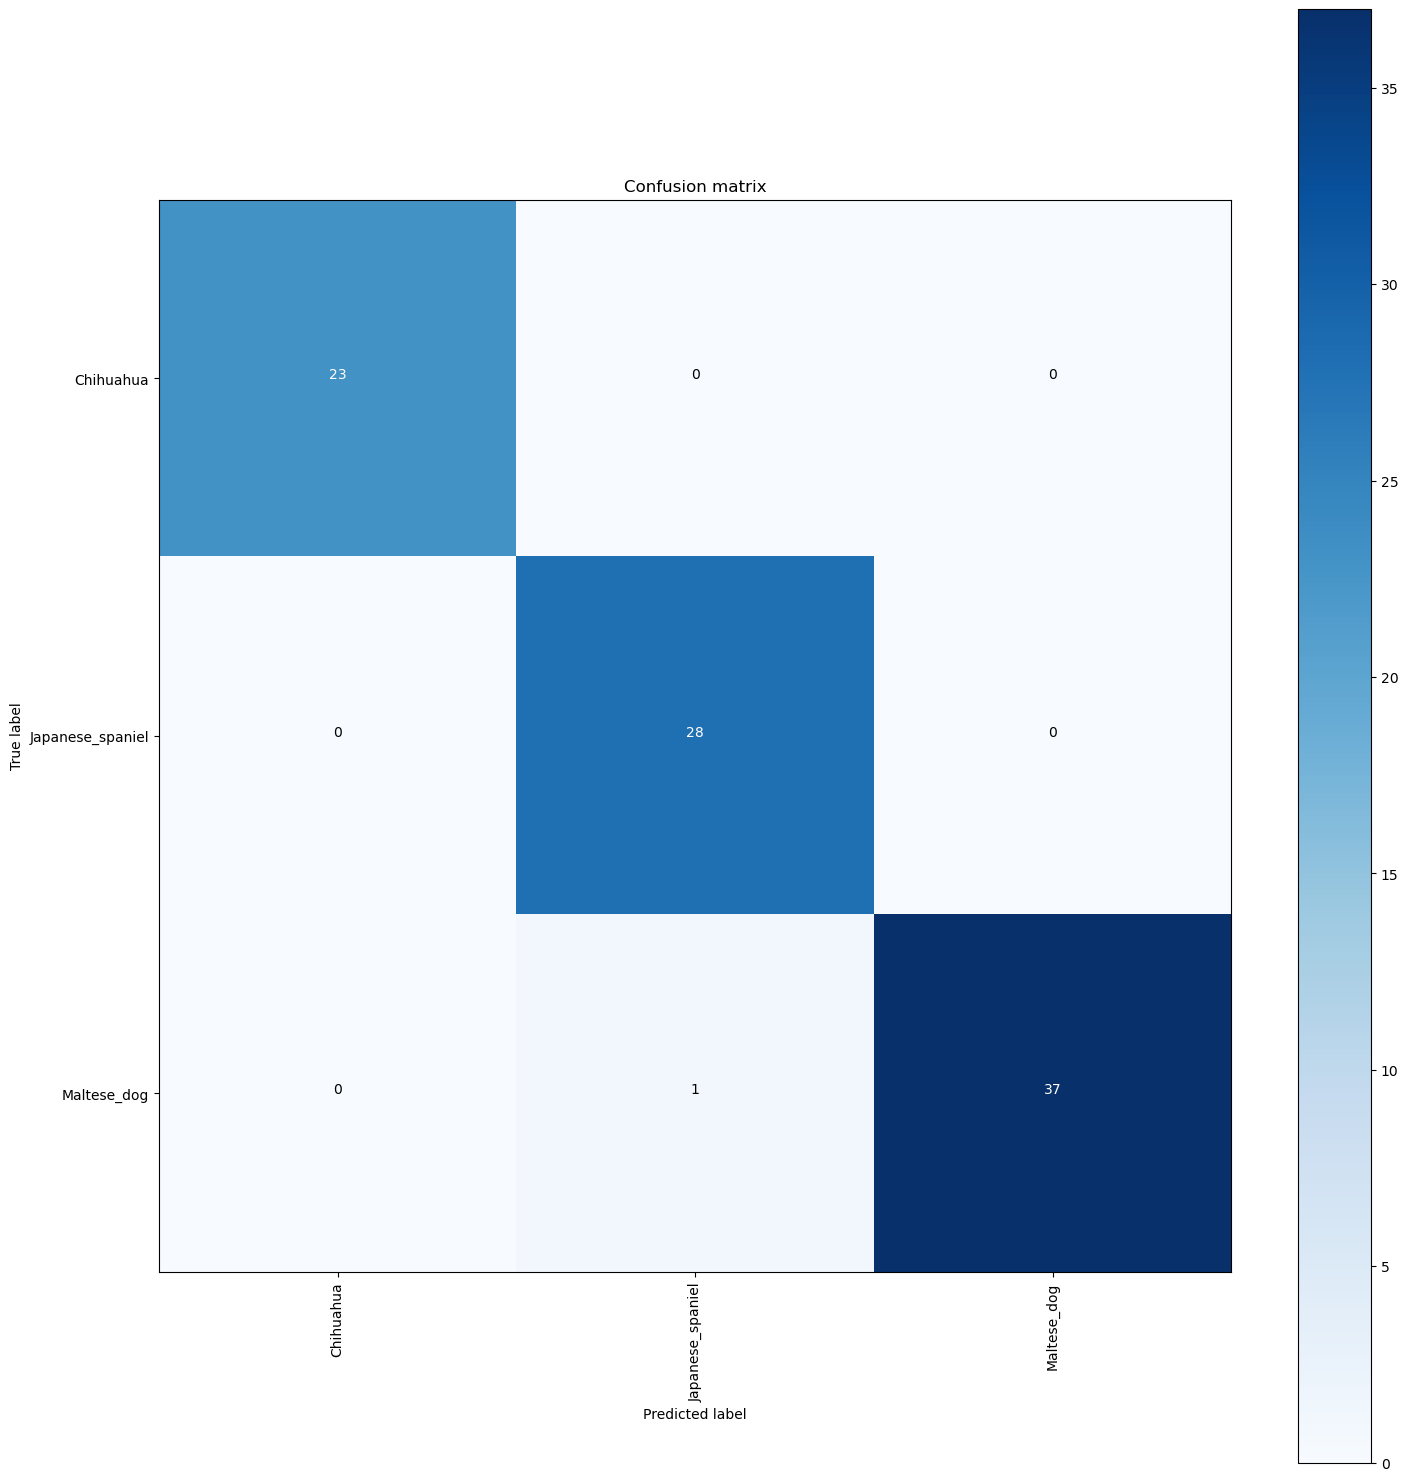

In [21]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()

# 5 breeds

## Data preparation

In [22]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 666 images belonging to 5 classes.
Found 143 images belonging to 5 classes.
Found 143 images belonging to 5 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

Loaded test images in test_features array: (143, 299, 299, 3)


## Model

In [23]:
conv_base = InceptionV3(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [24]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 149, 149, 32) 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 149, 149, 32) 0           batch_normalization_189[0][0]    
_______________________________________________________________________________________

In [25]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(len(classes_labels), activation='softmax'))

conv_base.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_inceptV3_data_aug_5_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_inceptV3_data_aug_5_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 15s - loss: 1.3619 - acc: 0.5495 - val_loss: 0.2483 - val_acc: 0.9000

Epoch 00001: val_loss improved from inf to 0.24829, saving model to tl_freeze_conv_base_inceptV3_data_aug_5_breeds
Epoch 2/1000
 - 13s - loss: 0.7391 - acc: 0.7446 - val_loss: 0.0599 - val_acc: 0.9431

Epoch 00002: val_loss improved from 0.24829 to 0.05993, saving model to tl_freeze_conv_base_inceptV3_data_aug_5_breeds
Epoch 3/1000
 - 12s - loss: 0.6593 - acc: 0.7755 - val_loss: 0.0464 - val_acc: 0.9268

Epoch 00003: val_loss improved from 0.05993 to 0.04635, saving model to tl_freeze_conv_base_inceptV3_data_aug_5_breeds
Epoch 4/1000
 - 12s - loss: 0.5786 - acc: 0.7864 - val_loss: 0.0258 - val_acc: 0.9512

Epoch 00004: val_loss improved from 0.04635 to 0.02576, saving model to tl_freeze_conv_base_inceptV3_data_aug_5_breeds
Epoch 5/1000
 - 11s - loss: 0.5173 - acc: 0.7991 - val_loss: 0.0523 - val_acc: 0.9187

Epoch 00005: val_loss did not improve from 0.02576
Epoch 6/1000
 - 12s - loss: 0.4562 - acc: 

## Results

In [26]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

143/143 [==============================] - 1s 7ms/step


[0.2795218745624269, 0.9230769276618958]

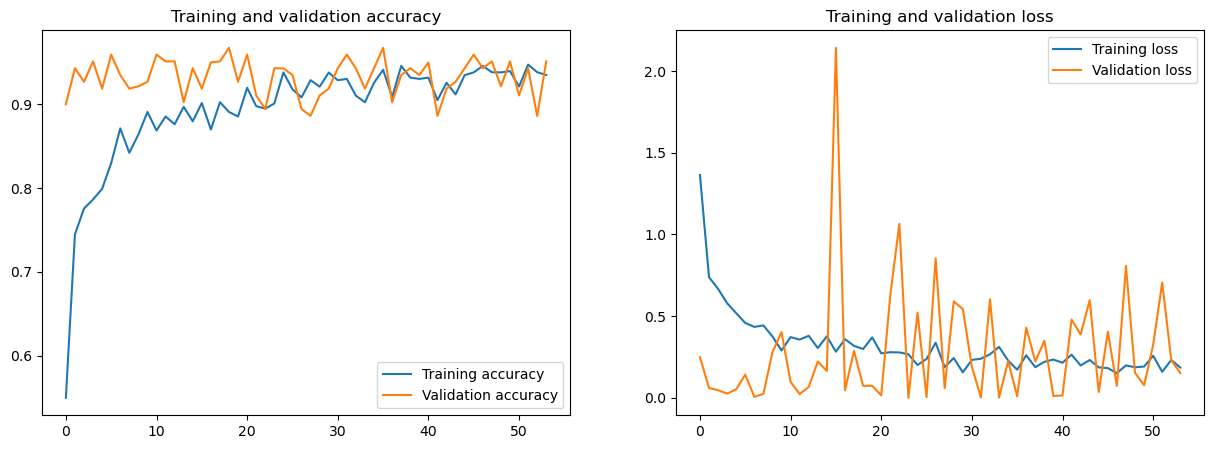

In [27]:
plot_accuracy_and_loss(history)

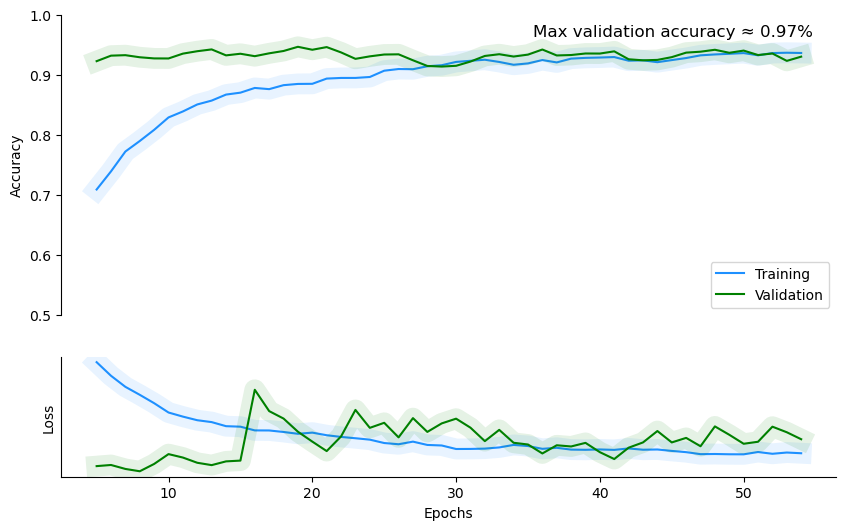

In [28]:
plot_history(history,xkcd=False)

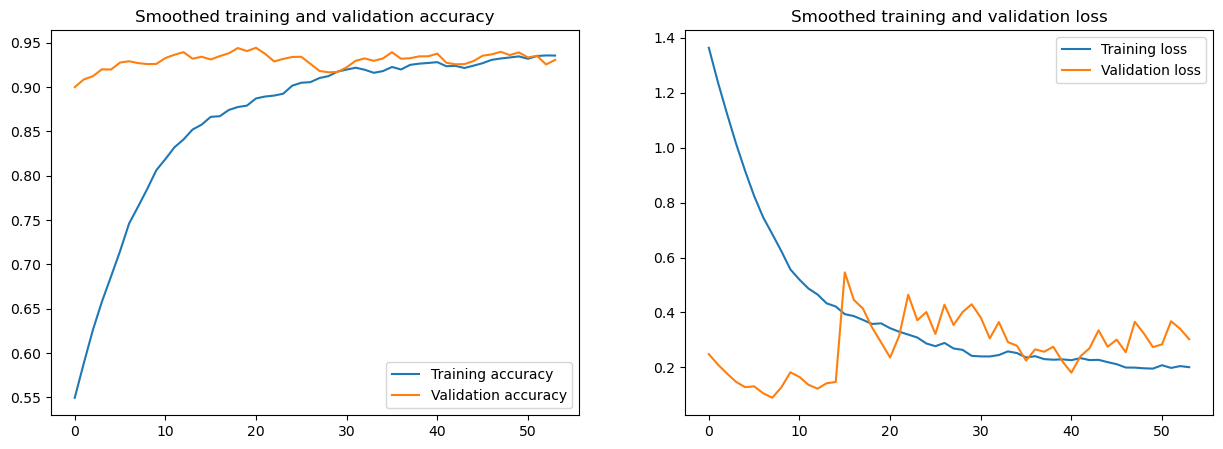

In [29]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

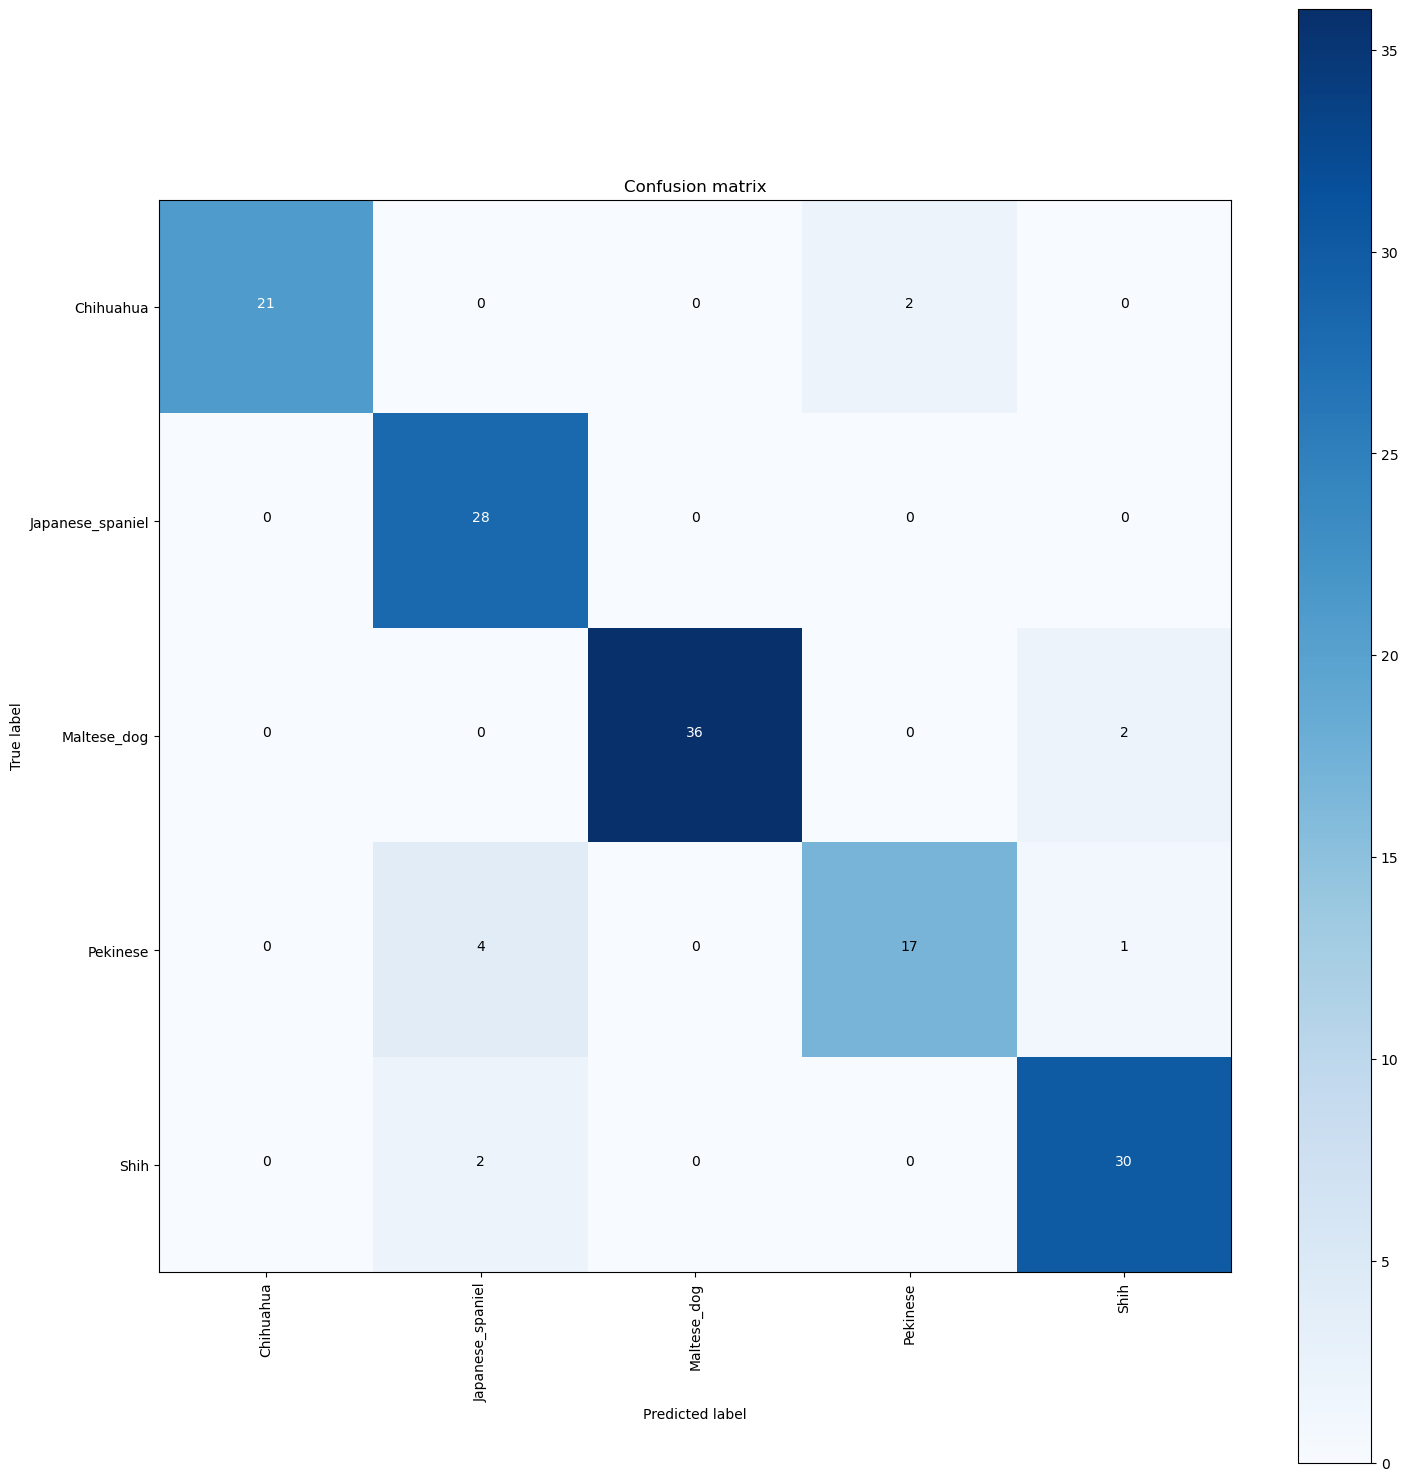

In [30]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()

# 60 breeds

## Data preparation

In [31]:
classes = os.listdir(PATH + train_dir)[:60]

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 7072 images belonging to 60 classes.
Found 1527 images belonging to 60 classes.
Found 1512 images belonging to 60 classes.

Stored classes labels in classes_labels:  ['affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'basenji', 'basset', 'beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'black', 'Blenheim_spaniel', 'bloodhound', 'bluetick', 'Border_collie', 'Border_terrier', 'borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'boxer', 'Brabancon_griffon', 'briard', 'Brittany_spaniel', 'bull_mastiff', 'cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly', 'Dandie_Dinmont', 'dhole', 'dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'flat', 'French_bulldog', 'German_shepherd', 'German_short', 'giant_schnauzer', 'golden_retriever', 'Gordon_setter', 'Greater_Swiss_Mountain_do

## Model

In [32]:
conv_base = InceptionV3(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [33]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_283 (Conv2D)             (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_283 (BatchN (None, 149, 149, 32) 96          conv2d_283[0][0]                 
__________________________________________________________________________________________________
activation_283 (Activation)     (None, 149, 149, 32) 0           batch_normalization_283[0][0]    
_______________________________________________________________________________________

In [34]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(len(classes_labels), activation='softmax'))

conv_base.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_data_inceptV3_aug_60_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_data_aug_inceptV3_60_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 144s - loss: 2.4570 - acc: 0.5061 - val_loss: 0.2056 - val_acc: 0.9046

Epoch 00001: val_loss improved from inf to 0.20562, saving model to tl_freeze_conv_base_data_inceptV3_aug_60_breeds
Epoch 2/1000
 - 136s - loss: 1.3699 - acc: 0.6739 - val_loss: 0.2503 - val_acc: 0.9031

Epoch 00002: val_loss did not improve from 0.20562
Epoch 3/1000
 - 137s - loss: 1.2090 - acc: 0.7090 - val_loss: 0.0458 - val_acc: 0.9237

Epoch 00003: val_loss improved from 0.20562 to 0.04579, saving model to tl_freeze_conv_base_data_inceptV3_aug_60_breeds
Epoch 4/1000
 - 135s - loss: 1.0865 - acc: 0.7336 - val_loss: 0.3158 - val_acc: 0.9098

Epoch 00004: val_loss did not improve from 0.04579
Epoch 5/1000
 - 135s - loss: 1.0582 - acc: 0.7484 - val_loss: 0.7034 - val_acc: 0.9257

Epoch 00005: val_loss did not improve from 0.04579
Epoch 6/1000
 - 135s - loss: 1.0093 - acc: 0.7568 - val_loss: 0.7199 - val_acc: 0.9224

Epoch 00006: val_loss did not improve from 0.04579
Epoch 7/1000
 - 134s - loss: 1.0

## Results

In [35]:
#VGG 16 WITHOUT DATA AUGMENTATION
#[2.104791192465989, 0.44113755226135254]
#VGG 16 WITH DATA AUGMENTATION
#[2.187684402204795, 0.4525904059410095]
#INCEPTIONV3 WITHOUT DATA AUGMENTATION
#[0.5336445021965398, 0.9113756418228149]
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

1512/1512 [==============================] - 15s 10ms/step


[0.4402667050703833, 0.9160053133964539]

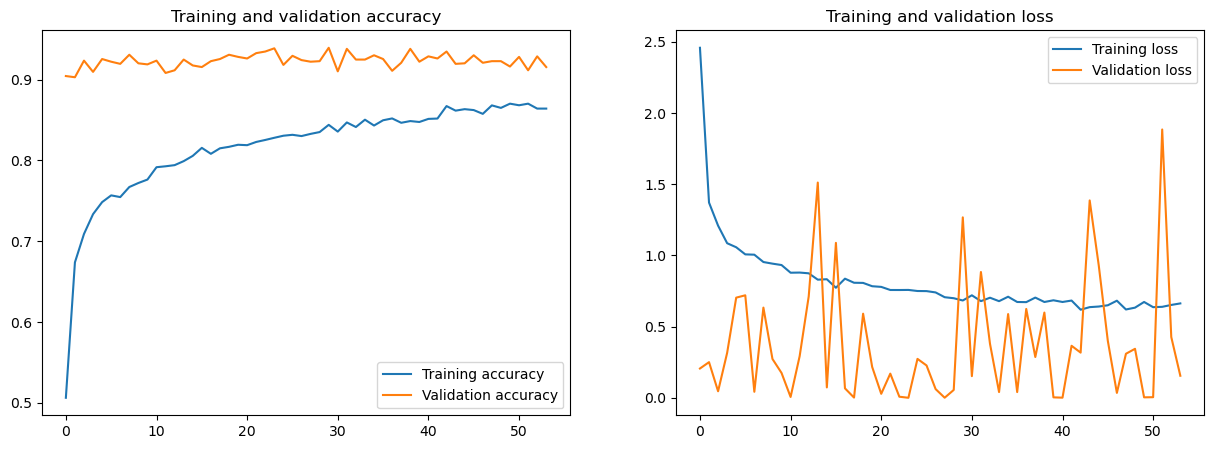

In [36]:
plot_accuracy_and_loss(history)

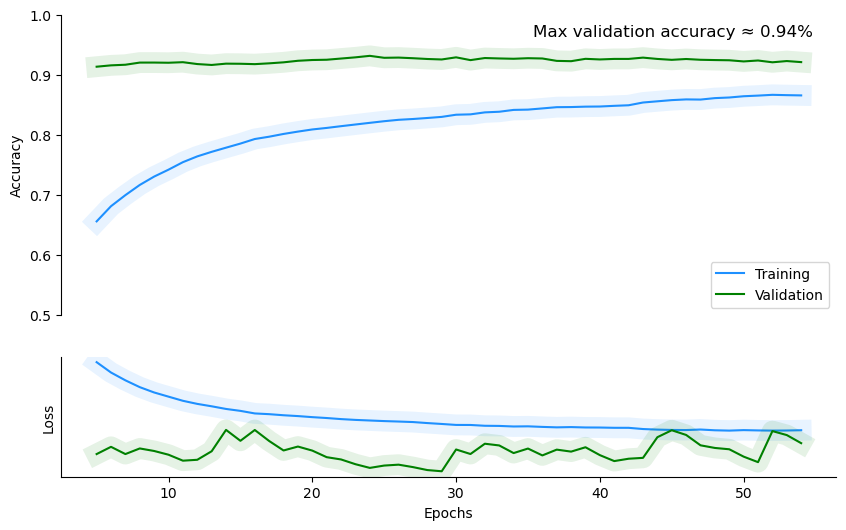

In [37]:
plot_history(history,xkcd=False)

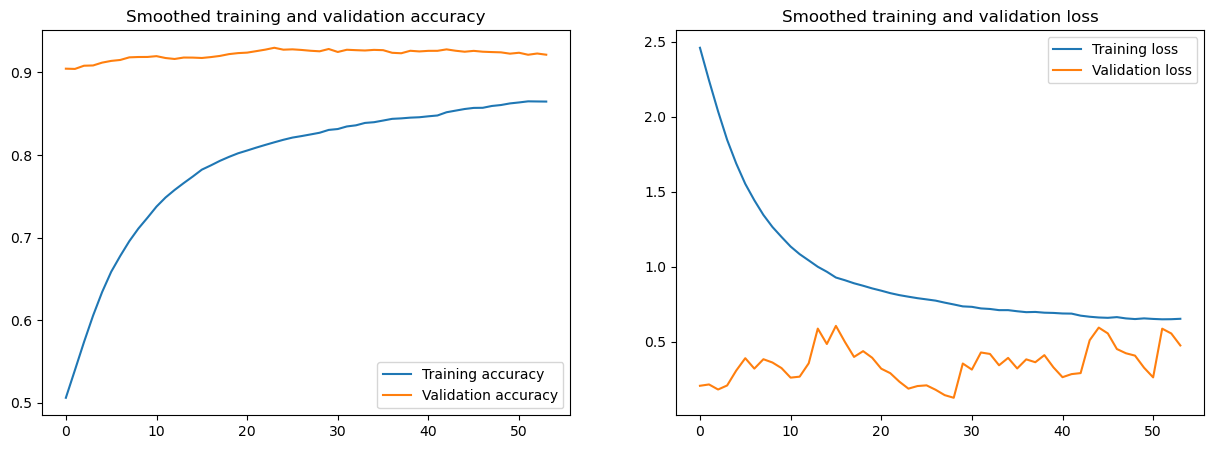

In [38]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

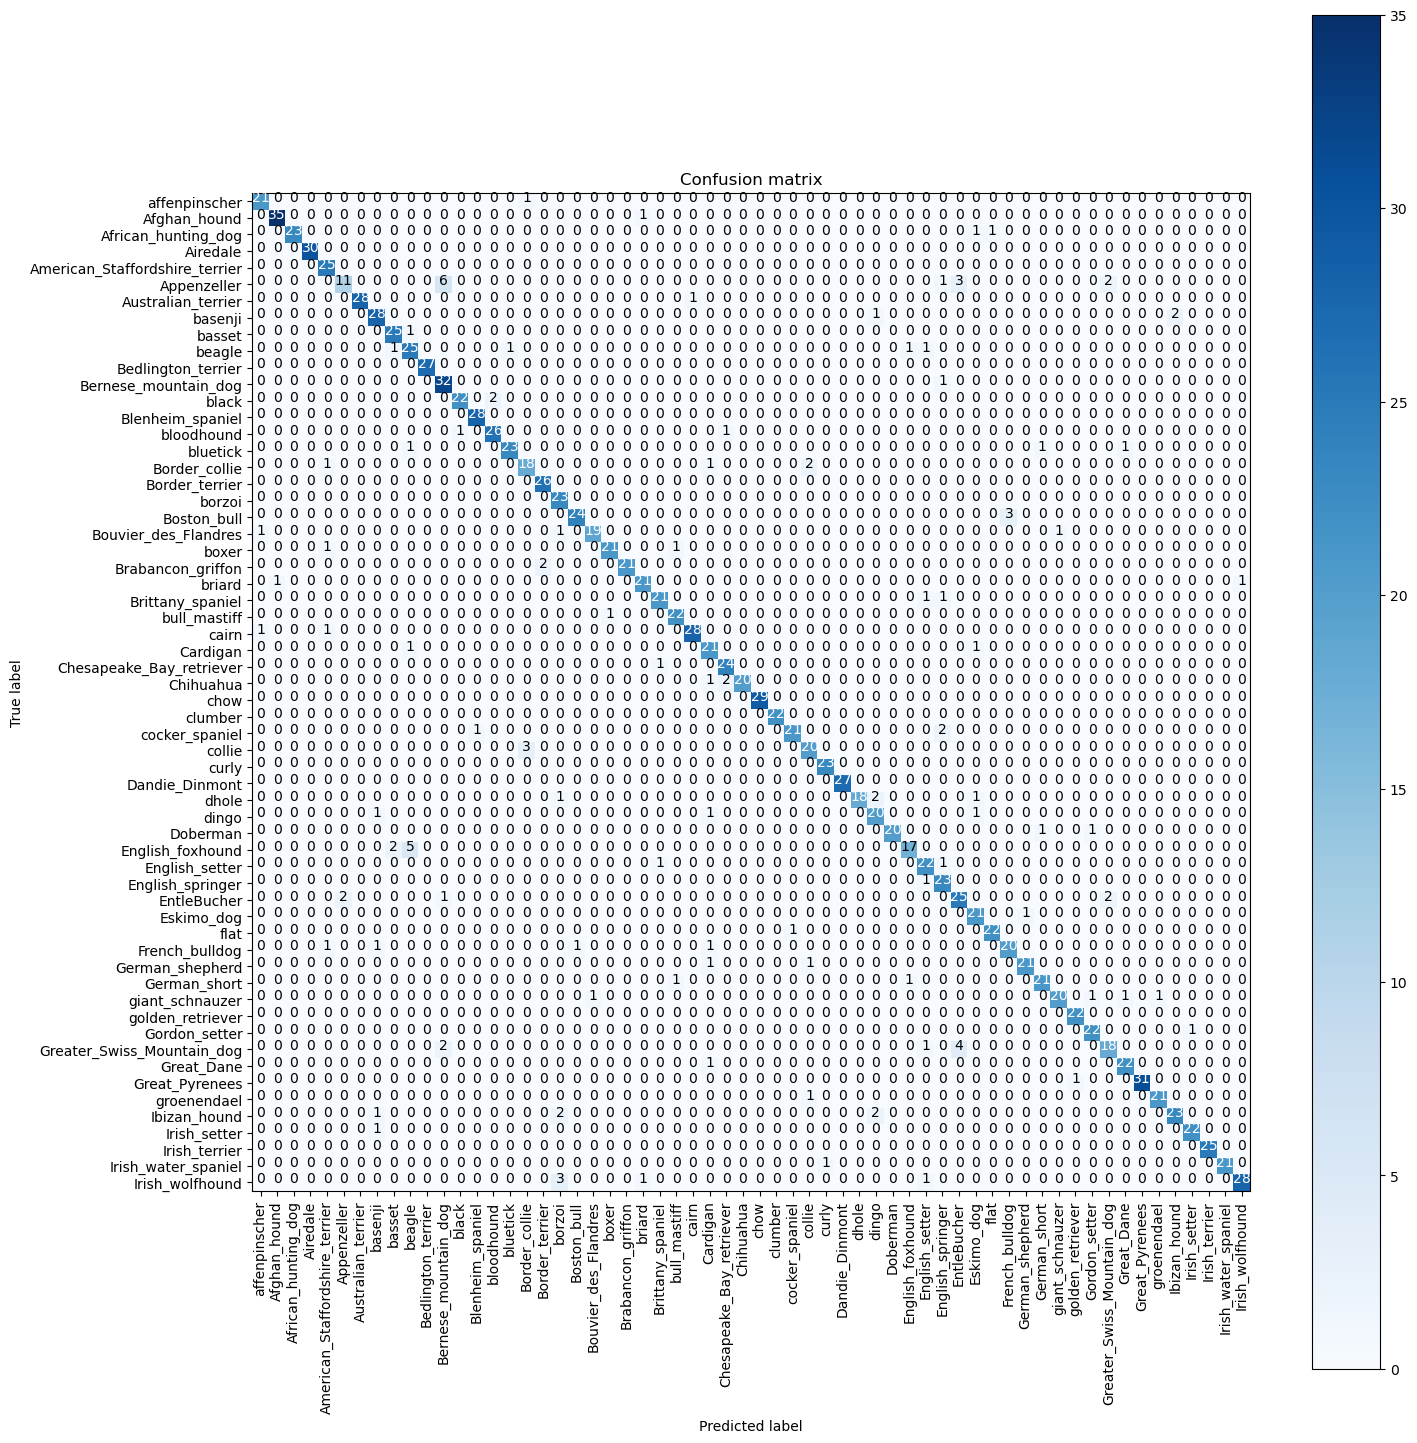

In [39]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()

# 120 breeds

## Data preparation

In [40]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 14397 images belonging to 120 classes.
Found 3099 images belonging to 120 classes.
Found 3084 images belonging to 120 classes.

Stored classes labels in classes_labels:  ['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', '

# Model

In [41]:
conv_base = InceptionV3(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [42]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_377 (Conv2D)             (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_377 (BatchN (None, 149, 149, 32) 96          conv2d_377[0][0]                 
__________________________________________________________________________________________________
activation_377 (Activation)     (None, 149, 149, 32) 0           batch_normalization_377[0][0]    
_______________________________________________________________________________________

In [43]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(len(classes_labels), activation='softmax'))

conv_base.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_inceptV3_data_aug_120_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_inceptV3_data_aug_120_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 299s - loss: 2.8238 - acc: 0.4168 - val_loss: 0.9510 - val_acc: 0.7984

Epoch 00001: val_loss improved from inf to 0.95102, saving model to tl_freeze_conv_base_inceptV3_data_aug_120_breeds
Epoch 2/1000
 - 291s - loss: 1.7657 - acc: 0.5767 - val_loss: 0.4123 - val_acc: 0.8133

Epoch 00002: val_loss improved from 0.95102 to 0.41225, saving model to tl_freeze_conv_base_inceptV3_data_aug_120_breeds
Epoch 3/1000
 - 305s - loss: 1.6252 - acc: 0.6103 - val_loss: 0.3662 - val_acc: 0.8383

Epoch 00003: val_loss improved from 0.41225 to 0.36618, saving model to tl_freeze_conv_base_inceptV3_data_aug_120_breeds
Epoch 4/1000
 - 287s - loss: 1.5412 - acc: 0.6314 - val_loss: 0.5317 - val_acc: 0.8506

Epoch 00004: val_loss did not improve from 0.36618
Epoch 5/1000
 - 281s - loss: 1.4511 - acc: 0.6486 - val_loss: 1.3911 - val_acc: 0.8477

Epoch 00005: val_loss did not improve from 0.36618
Epoch 6/1000
 - 277s - loss: 1.4072 - acc: 0.6641 - val_loss: 0.7370 - val_acc: 0.8470

Epoch 00006

## Results

In [44]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

3084/3084 [==============================] - 323s 105ms/step


[1.0566401467593654, 0.8566796183586121]

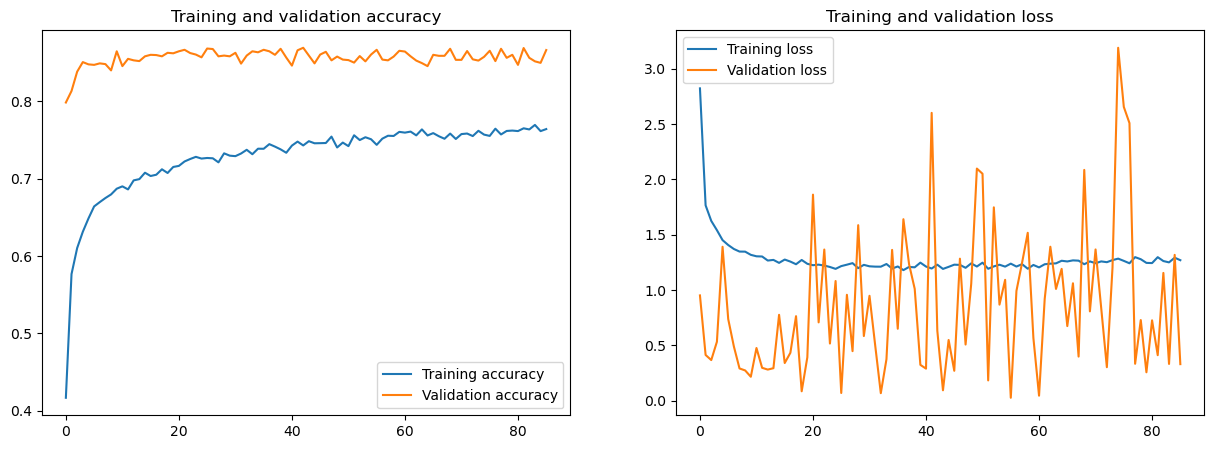

In [45]:
plot_accuracy_and_loss(history)

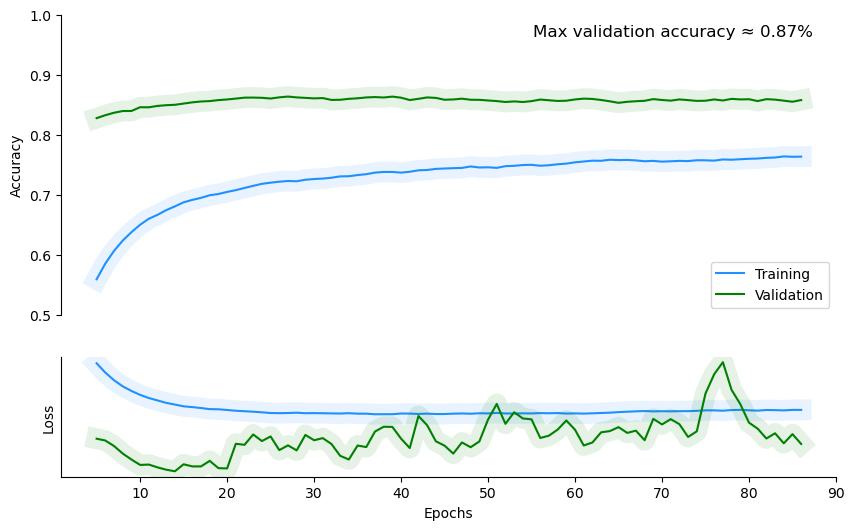

In [46]:
plot_history(history,xkcd=False)

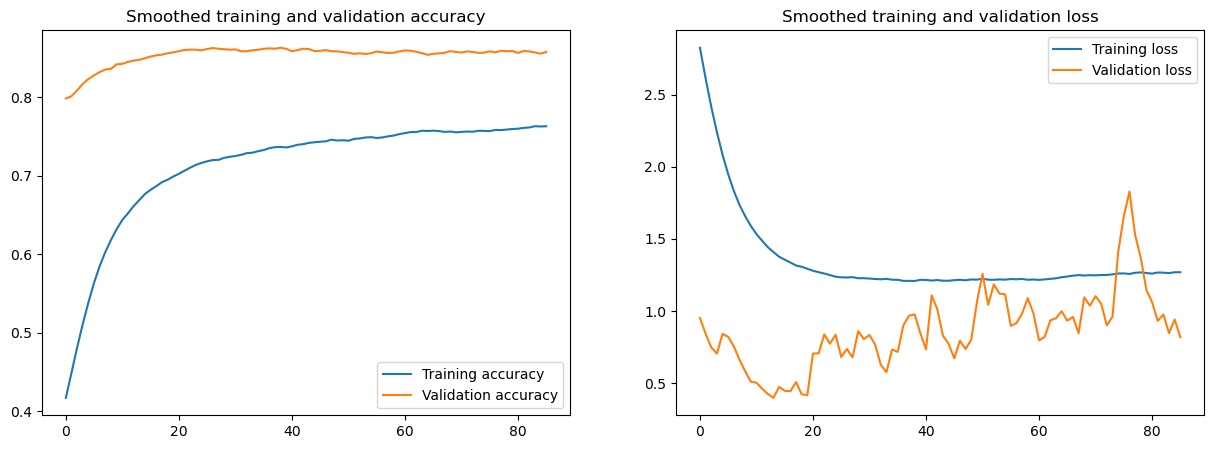

In [47]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

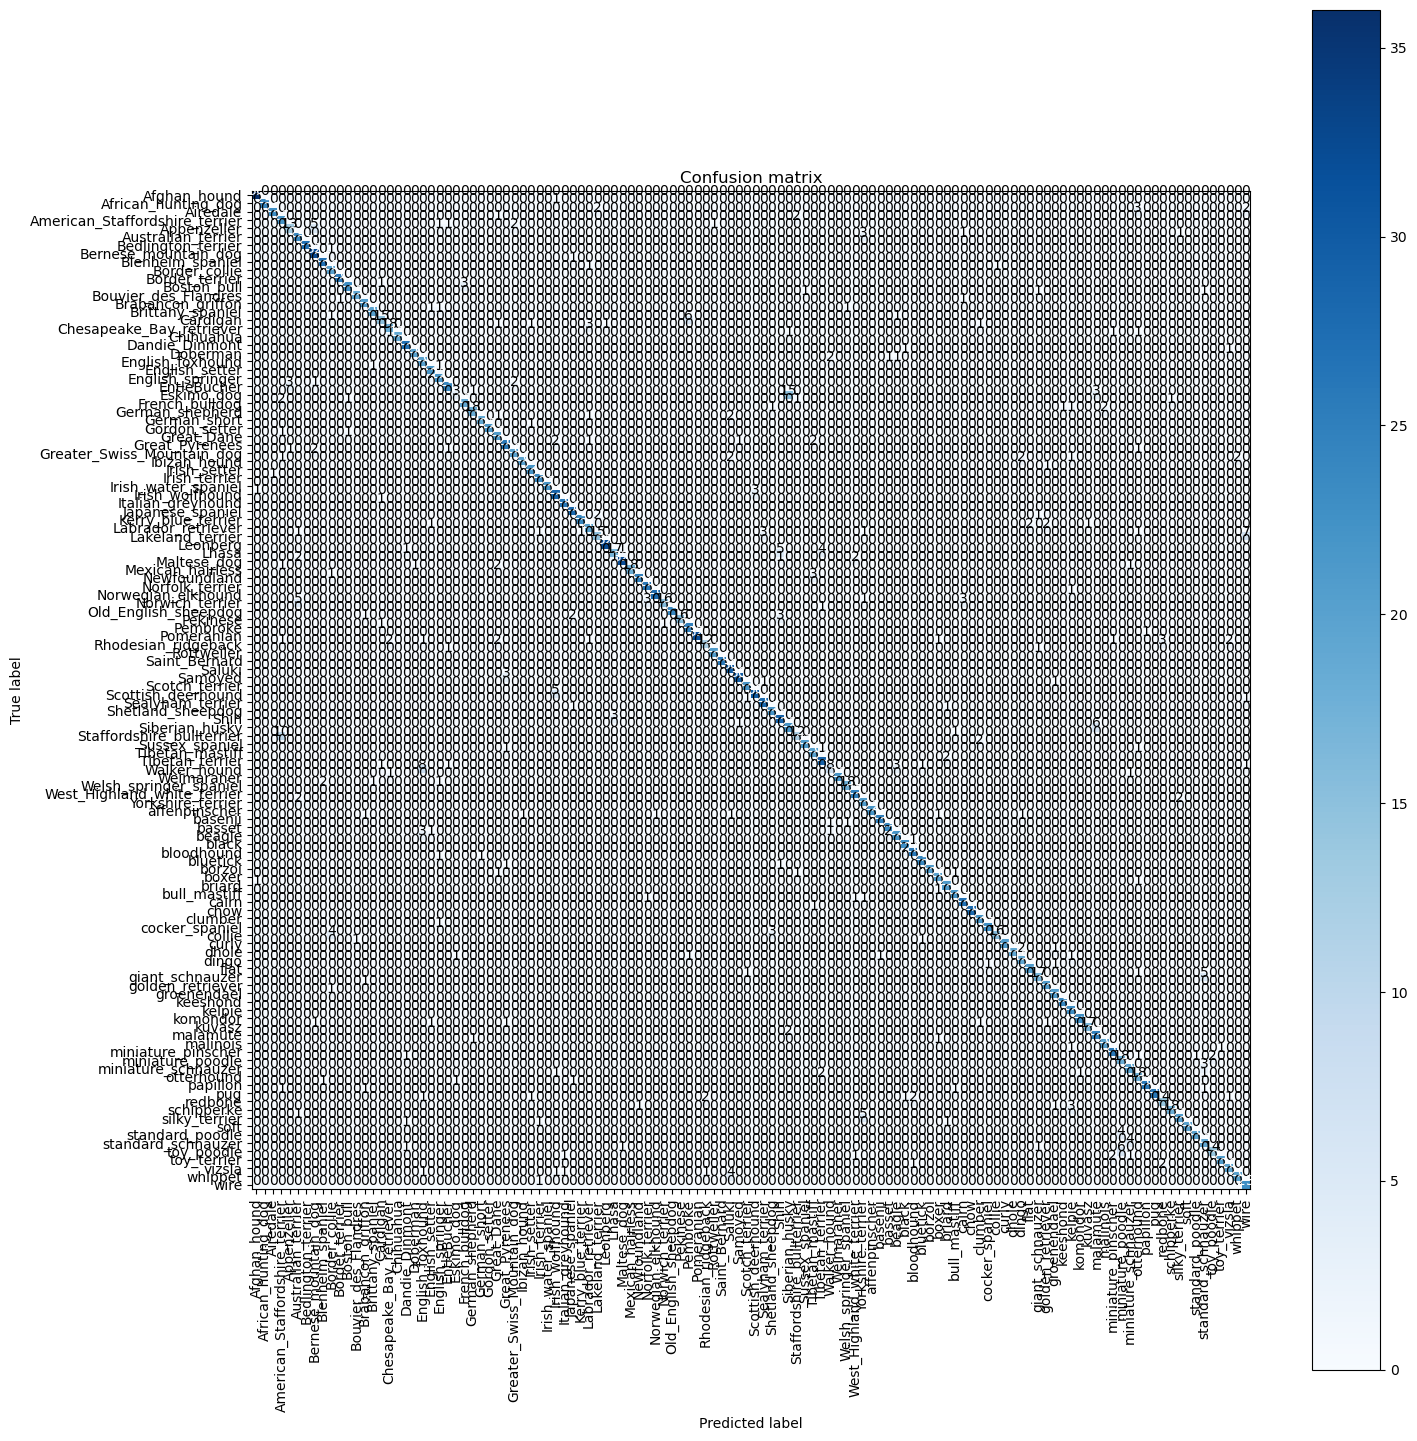

In [48]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()